In [655]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [896]:
from carl.distributions import Mixture, MultivariateNormal

def generate(n_samples, nuisance=0.0):
    p = Mixture(components=[MultivariateNormal(mu=np.array([0., 2.]), sigma=np.eye(2)), 
                            MultivariateNormal(mu=np.array([0., -2.]), sigma=np.eye(2))])
    q = MultivariateNormal(mu=np.array([0, 0.]), sigma=np.eye(2))
    
    if nuisance == "random":
        z = np.random.rand(n_samples) * 6. - 3.
    else:
        z = np.ones(n_samples) * nuisance
    v = np.zeros((n_samples, 2))
    v[:, 0] += z
        
    X = np.vstack([p.rvs(n_samples // 2), q.rvs(n_samples // 2) + v[n_samples // 2:]])
    y = np.zeros(n_samples)
    y[n_samples // 2:] = 1
    
    return X, y, z

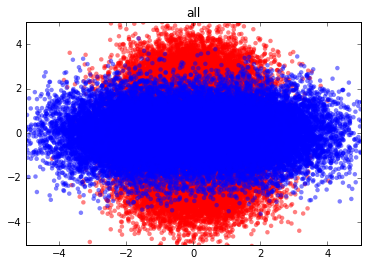

In [897]:
X, y, z = generate(50000, nuisance="random")

plt.title("all")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none", alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none", alpha=0.5)

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [898]:
X.shape, y.shape, z.shape

((50000, 2), (50000,), (50000,))

In [970]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(64, activation="relu")(inputs)
Dx = Dense(64, activation="relu")(Dx)
Dx = Dense(64, activation="relu")(Dx)
Dx_fork = Dx
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(64, activation="relu")(Rx)
mu = Dense(1, activation="tanh")(Rx)
mu = Lambda(lambda x: 5*x)(mu)
sigma = Dense(1, activation="relu")(Rx)
sigma = Lambda(lambda x: 0.1 + x)(sigma)
Rx = Merge(mode="concat")([mu, sigma])

R = Model(input=[inputs], output=[Rx])

In [971]:
R.predict(X[:10])

array([[ 0.29586509,  0.13044868],
       [ 0.27818707,  0.12862548],
       [ 0.27050141,  0.12783307],
       [ 0.29164815,  0.1300137 ],
       [ 0.2880387 ,  0.12964141],
       [ 0.29029781,  0.12987442],
       [ 0.26869884,  0.12764724],
       [ 0.29427323,  0.13028449],
       [ 0.28700906,  0.12953523],
       [ 0.28355765,  0.12917928]], dtype=float32)

In [972]:
from keras.optimizers import Adam, SGD
import keras.backend as K
import theano.tensor as T

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        y_true = y_true.ravel()
        y_pred = y_pred.ravel()
        return c * ((1.0 - y_true) * (K.log(1.0 - y_pred)) + (y_true) * (K.log(y_pred))) 

    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        a = -5.0
        b = 5.0
        
        z = z_true.ravel()
        mu = z_pred[:, 0].ravel() 
        sigma = z_pred[:, 1].ravel() 
        
        ll = (-K.log(sigma) 
              -np.log(np.sqrt(2. * np.pi)) 
              -((z - mu) ** 2 / (2. * sigma ** 2))
              +np.log(2.)
              -K.log(T.erf((b - mu) / (sigma * np.sqrt(2.))) - 
                     T.erf((a - mu) / (sigma * np.sqrt(2.)))))
        
        return -c * ll.mean()
    
    return loss_R

opt_DRf = Adam()
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=-1.0), 
                  make_loss_R(c=-10.0)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = Adam() # SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [973]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_93 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_281 (Model)                (None, 1)             8577        input_93[0][0]                   
____________________________________________________________________________________________________
model_282 (Model)                (None, 2)             17155       input_93[0][0]                   
Total params: 25732
____________________________________________________________________________________________________


In [974]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_93 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_282 (Model)                (None, 2)             17155       input_93[0][0]                   
Total params: 17155
____________________________________________________________________________________________________


In [975]:
DRf.predict(X[:3])

[array([[ 0.54862881],
        [ 0.51577812],
        [ 0.50150025]], dtype=float32), array([[ 0.29586491,  0.13044867],
        [ 0.27818707,  0.12862548],
        [ 0.27050143,  0.12783305]], dtype=float32)]

In [976]:
DfR.predict(X[:3])

array([[ 0.29586491,  0.13044867],
       [ 0.27818707,  0.12862548],
       [ 0.27050143,  0.12783305]], dtype=float32)

In [977]:
# Pretraining
D.trainable = False
R.trainable = True
DfR.fit(X, z, nb_epoch=10)

Epoch 1/10
50000/50000 [==============================] - 1s - loss: 2.5220     
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.9615     
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.9616     
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.9615     
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.9602     
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.9587     
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 1.9567     
Epoch 8/10
50000/50000 [==============================] - 1s - loss: 1.9552     
Epoch 9/10
50000/50000 [==============================] - 1s - loss: 1.9545     
Epoch 10/10
50000/50000 [==============================] - 1s - loss: 1.9540     


In [978]:
DfR.predict(X[:10]), z[:10]

(array([[ 0.2175618 ,  1.89622521],
        [ 0.23198298,  1.60735011],
        [ 0.23403478,  1.49122691],
        [ 0.22784127,  1.81682253],
        [ 0.22921568,  1.75784731],
        [ 0.22845881,  1.79444742],
        [ 0.23447394,  1.46406722],
        [ 0.22287208,  1.86472797],
        [ 0.22956885,  1.74155569],
        [ 0.23054075,  1.68882203]], dtype=float32),
 array([ 0.03414993,  2.16018588, -0.32119594,  1.81518953, -1.57659574,
         1.90225282, -2.97410899, -2.50371248, -2.74218349,  0.55196378]))

In [979]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.title("iteration = %d" % i)
    
    for label, values in losses.items():
        plt.plot(range(len(values)), values, label=label)
        
    plt.legend(loc="best")
    plt.show()

In [980]:
losses = {"L_d": [], "L_r": [], "L_d - L_r": []}

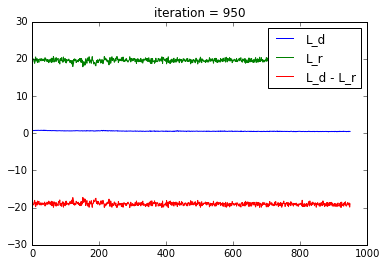

In [981]:
batch_size = 128

for i in range(1000):
    if i % 50 == 0:
        D.trainable = False
        R.trainable = True
        DfR.fit(X, z, nb_epoch=1)
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X))[:batch_size]
    l = DRf.train_on_batch(X[indices], [y[indices], z[indices]])
    
    losses["L_d - L_r"].append(l[0][None][0])
    losses["L_d"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(20):
        indices = np.random.permutation(len(X))[:batch_size]
        DfR.train_on_batch(X[indices], z[indices])

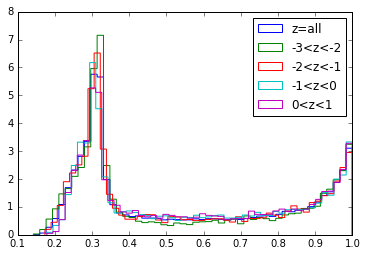

In [982]:
plt.hist(1. - D.predict(X), bins=50, normed=1, histtype="step", label="z=all")
plt.hist(1. - D.predict(X[(-3 < z) & (z < -2)]), bins=50, normed=1, histtype="step", label="-3<z<-2")
plt.hist(1. - D.predict(X[(-2 < z) & (z < -1)]), bins=50, normed=1, histtype="step", label="-2<z<-1")
plt.hist(1. - D.predict(X[(-1 < z) & (z < -0)]), bins=50, normed=1, histtype="step", label="-1<z<0")
plt.hist(1. - D.predict(X[(0 < z) & (z < 1)]), bins=50, normed=1, histtype="step", label="0<z<1")
plt.legend(loc="best")
plt.show()

Looks pivotal!

For comparison, here is how it looks without constraint:

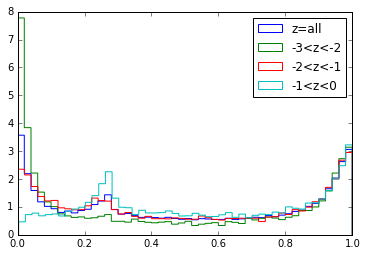

In [927]:
plt.hist(1. - D.predict(X), bins=50, normed=1, histtype="step", label="z=all")
plt.hist(1. - D.predict(X[(-3 < z) & (z < -2)]), bins=50, normed=1, histtype="step", label="-3<z<-2")
plt.hist(1. - D.predict(X[(-2 < z) & (z < -1)]), bins=50, normed=1, histtype="step", label="-2<z<-1")
plt.hist(1. - D.predict(X[(-1 < z) & (z < -0)]), bins=50, normed=1, histtype="step", label="-1<z<0")
plt.legend(loc="best")
plt.show()

In [988]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 20. 
X_test[:, 0] -= 10.
X_test[:, 1] *= 20. 
X_test[:, 1] -= 10.
y_pred = D.predict(X_test).ravel()

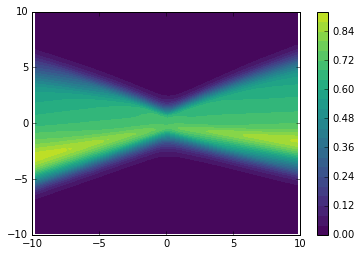

In [989]:
from matplotlib.mlab import griddata
xi = np.linspace(-10, 10., 100)
yi = np.linspace(-10, 10., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 25, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

For comparison here is the decision surface when trained without constraint:

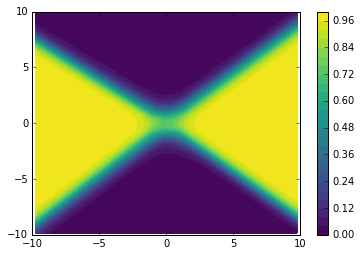

In [929]:
from matplotlib.mlab import griddata
xi = np.linspace(-10, 10., 100)
yi = np.linspace(-10, 10., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 25, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 